In [1]:
from bs4 import BeautifulSoup
from time import sleep
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
import eutils
import requests
import xml
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

### Data

In [2]:
def check_ortho_terms(word, terms):
    for x in terms:
        if x.lower() in word.lower():
            return True
    return False

ortho_terms = ['spine', 'ortho', 'knee', 'foot', 'musclulo', 'bone']

In [5]:
f = open("medical.txt", "r", encoding="utf8")
abrv_dict = {}
for line in f.readlines():
    line = line.strip().split('\t')
    abrv_dict[line[0].lower()] = line[1:]

In [6]:
names = pd.read_excel('ortho_providers.xlsx')
# abrv_dict = pickle.load(open('abrv_dict.pkl', 'rb'))
ortho_journals_full = pickle.load(open('ortho_journals_full.pkl', 'rb'))
ortho_journals = set([])
bad_count = 0
good_count = 0
for x in bad_ortho:
    # print(x)
    if x.lower() in abrv_dict:
        for i in abrv_dict[x.lower()]:
            ortho_journals.add(i)
        good_count += 1
    else:            
        # print(index, x.Journal)
        # for i in abrv_dict.keys():
        #     if x.Journal in i:
        #         ortho_journals.add(abrv_dict[i])
        #         print(f'found: {i}, original: {x.Journal}')
        bad_count += 1
        # print(x)

for x in abrv_dict:
    if check_ortho_terms(x, ortho_terms):
        for i in abrv_dict[x]:
            ortho_journals.add(i)

print(bad_count)
print(good_count)

print(len(ortho_journals))

FileNotFoundError: [Errno 2] No such file or directory: 'RCR.xlsx'

### Eutiles

In [5]:
ec = eutils.Client(api_key='06dd8203829833ed73d70a28375e2c231808')

In [6]:
def esearch_query(payload, retmax = 100000, sleep=0.34):
    """
    Return identifiers using the ESearch E-utility.
    """
    url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'
    payload['rettype'] = 'xml'
    payload['retmax'] = retmax
    payload['retstart'] = 0
    ids = list()
    count = 1
    while payload['retstart'] < count:
        response = requests.get(url, params=payload)
        tree = xml.etree.ElementTree.fromstring(response.text)
        count = int(tree.findtext('Count'))
        ids += [id_.text for id_ in tree.findall('IdList/Id')]
        payload['retstart'] += retmax
        # print('esearch {:.3%} complete'.format(payload['retstart'] / count), end='\r')
        time.sleep(sleep)
    return ids

In [7]:
def divide_chunks(l, n):
     
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [8]:
def get_ortho_pubs(pubmed_ids, ortho_journals):
    count = 0
    authors = []
    if len(pubmed_ids) > 0:

        id_lists = list(divide_chunks(list(pubmed_ids), 250))

        for id_chunk in id_lists:
            paset = ec.efetch(db='pubmed', id=id_chunk)
            for pa in paset:
                # print(pa.jrnl)
                if pa.jrnl.lower() in ortho_journals or check_ortho_terms(pa.jrnl.lower(), ortho_terms):
                    count += 1
                    authors.append(pa.authors)
        if len(authors) == 0:
            for id_chunk in id_lists:
                paset = ec.efetch(db='pubmed', id=pubmed_ids)
                for pa in paset:
                    authors.append(pa.authors)
    return count, authors

In [9]:
def author_check(author_last, ortho_journals):
    payload = {'db': 'pubmed', 'term': author_last}
    pubmed_ids = set(esearch_query(payload))
    journal_count, authors = get_ortho_pubs(pubmed_ids, ortho_journals)
    viable_authors = {}
    for author_group in authors:
        for author in author_group:
            if author_last in author.lower():
                if author.lower() not in viable_authors:
                    viable_authors[author.lower()] = 1
                else:
                    viable_authors[author.lower()] += 1
    return viable_authors
        


In [10]:
def get_author_name(author):
    viable_authors = author_check(author, ortho_journals)
    max_key =''
    max_value = 0
    if len(viable_authors) > 0:
        for key in viable_authors:
            if viable_authors[key] > max_value:
                max_key = key
                max_value = viable_authors[key]
    return max_key
        

In [11]:
# author_best_names = {}
author_best_names = pickle.load(open('author_best_names.pkl', 'rb'))
names_list = []
bad_authors = []
start_name = {}
for index, x in names.iterrows():
    name = x.Name
    name = name.split(",")
    name = name[0].split(" ")
    name = name[-1].lower() + ' ' + name[0][0].lower()
    names_list.append(name)
    start_name[x.Name.split(", ")[0].lower()] = name
# for name in tqdm(names_list):
#     if name not in author_best_names:
#         try:
#             search_name = get_author_name(name)
#             sleep(1)
#             author_best_names[name] = search_name
#         except:
#             bad_authors.append(name)
#         pickle.dump(author_best_names,  open('author_best_names.pkl', 'wb'))
#         pickle.dump(bad_authors,  open('bad_authors.pkl', 'wb'))


print(author_best_names)

{'delbello d': 'delbello d', 'walick k': 'walick ks', 'ty j': 'ty jm', 'riley p': 'riley po', 'handler-matasar s': 'handler-matasar s', 'ritzman t': 'ritzman tf', 'polousky j': 'polousky jd', 'bono k': 'bono kt', 'mackenzie w': 'mackenzie wg', 'gabos p': 'gabos pg', 'atanda a': 'atanda a', 'davey j': 'davey jr', 'bueche m': 'bueche mj', 'king e': 'king e', 'swaroop v': 'swaroop vt', 'sarwark j': 'sarwark jf', 'janicki j': 'janicki ja', 'grayhack j': 'grayhack jj', 'brasher a': 'brasher ae', 'sees j': 'sees jp', 'schoenleber s': 'schoenleber sj', 'mccarthy r': 'mccarthy re', 'blasier r': 'blasier rd', 'waanders n': 'waanders na', 'herrera-soto j': 'herrera-soto ja', 'toledano j': 'toledano j', 'ashberg l': 'ashberg l', 'waters p': 'waters pm', 'cearley d': 'cearley d', 'vu l': 'vu l', 'miller r': 'miller r', 'saldana r': 'saldana re', 'dutkowsky j': 'dutkowsky jp', 'culotta b': 'culotta ba', 'faust j': 'faust j', 'deignan b': 'deignan bj', 'schick p': 'schick pk', 'sponseller p': 'spons

In [71]:
# ortho_abrvs = set([])
# ortho_done = set([])
# bad_ortho = set([])

for x in tqdm(ortho_journals_full):
    if x not in ortho_done or x in bad_ortho:
        if x[-5:] == ', the':
            x = x[:-5]
            print(x)
        results = ec.esearch(db='pubmed', term=f'{x}[journal]')
        if len(results.ids) != 0:
            paset = ec.efetch(db='pubmed', id=results.ids)
            for pa in paset:
                x = x + ', the'
                ortho_abrvs.add(pa.jrnl)
                ortho_done.add(x)
                if x in bad_ortho:
                    print('here')
                    bad_ortho.remove(x)
                break
        else:
            bad_ortho.add(x)
            ortho_done.add(x)

 42%|████▏     | 127/306 [00:06<00:07, 23.49it/s]

journal of hand surgery asian-pacific volume


 42%|████▏     | 130/306 [00:08<00:16, 10.64it/s]

here


 68%|██████▊   | 208/306 [00:14<00:13,  7.33it/s]

journal of the american academy of orthopaedic surgeons


 68%|██████▊   | 209/306 [00:16<00:32,  3.00it/s]

here


100%|██████████| 306/306 [00:21<00:00, 14.12it/s]


In [74]:
pickle.dump(ortho_abrvs,  open('ortho_abrvs.pkl', 'wb'))
pickle.dump(bad_ortho,  open('bad_ortho.pkl', 'wb'))

In [13]:
pickle.dump(author_best_names,  open('author_best_names.pkl', 'wb'))

### Icare

In [3]:
def parse2(url):
    service = Service(ChromeDriverManager().install())
    options = Options()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    options.add_argument('--log-level=3')
    driver = webdriver.Chrome(service=service, options=options)
    driver.get(url)
    return driver

In [4]:
author_best_names = pickle.load(open('author_best_names.pkl', 'rb'))
bad_authors = pickle.load(open('bad_authors.pkl', 'rb'))
# author_name_to_values = pickle.load(open('author_name_to_values_only_ortho.pkl', 'rb'))
author_best_names_reverse = {author_best_names[x]:x for x in author_best_names}

In [6]:
ortho_abrvs = pickle.load(open('ortho_abrvs.pkl', 'rb'))
bad_ortho = pickle.load(open('bad_ortho.pkl', 'rb'))

In [4]:
df = pd.DataFrame(ortho_abrvs, columns = ['Journal Name.csv'])
df.to_csv('Journal_List.csv')

In [7]:
test = '''Eur Spine J

Bone Res

Clin Spine Surg

J Orthop Surg

J Pediatr Orthop B

Bone Res

J Bone Joint Surg Am

J Spinal Disord Tech

J Orthop Res

Skeletal Radiol

J Orthop Trauma

Iowa Orthop J

Scoliosis Spinal Disorders'''
test2 = '''Int J Sports Phys Ther

J Shoulder Elbow Surg

Arthroscopy

J Bone Joint Surg Am

J Foot Ankle Surg Am

J Hand Surg Am

Orthop Nurs'''

test = test.split('\n')[::2]
test2 = test2.split('\n')[::2]
test3 = test+test2
for x in test3:
    if x not in ortho_abrvs:
        ortho_abrvs.add(x)

In [10]:
name_dic = {}
for index, x in names.iterrows():
    name = x.Name
    name = name.split(",")
    name = name[0].split(" ")
    name = name[-1].lower() + ' ' + name[0][0].lower()
    name_dic[x.Name.split(", ")[0].lower()] = name

In [11]:
name_dic = {}
for index, x in names.iterrows():
    name = x.Name
    name = name.split(",")
    name = name[0].split(" ")
    if len(name) == 3:
        name = name[-1].lower() + ' ' + name[0][0].lower() + name[1][0].lower()
    else:
        name = name[0].lower() + " " + name[-1].lower()
    name_dic[name] = x.Name.split(", ")[0].lower()

In [12]:
def reverse_check(name):
    name = name_dic[author_best_names_reverse[name]]
    name = name.split(",")
    name = name[0].split(" ")
    name = name[0].lower() + ' ' + name[-1].lower()
    return name


In [28]:
def find_pmids(soup, ortho_abrvs):
    scripts = soup.find_all('script')
    if len(scripts) == 0:
        wanted_pmids = []
    wanted_pmids = []
    pmids = []
    journal_names = []
    for x in scripts:
        if x.text != '':
            chunks = x.text.split('\n')[1].strip()[19:-1].split(', ')
            for x in chunks:
                values = x.split(': ')
                if values[0].strip('"') == 'journalNameIso':
                    journal_names.append(values[1].strip('"'))
                if values[0].strip('"') == 'pmid':
                    pmids.append(values[1].strip('"'))
            wanted_pmids = []
            for x in range(len(journal_names)):
                if journal_names[x] in ortho_abrvs:
                    wanted_pmids.append(pmids[x])
    return wanted_pmids

In [26]:
max_journals = pd.read_excel('Max_journals.xlsx')
max_journals = max_journals.dropna()
max_journals = max_journals[max_journals['Include Journal (Y/N)'] == 'yes']
max_journals = list(max_journals.Journals.values)
for x in max_journals:
    ortho_abrvs.add(x)

In [17]:
data_points = ['total-pubs', 'pubs-per-year', 'cites-per-year-max', 'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med', 'rcr-max', 'rcr-mean', 'rcr-sem', 'rcr-med', 'wrcr']
author_name_to_journals = pickle.load(open('author_name_to_journals.pkl', 'rb'))

url = 'https://icite.od.nih.gov/analysis'
driver = parse2(url)

for x in tqdm(name_dic):
    if x not in author_name_to_journals:
        driver.find_element('id', 'pmid_query').send_keys(x)
        driver.find_element("id", 'process-btn').click()
        sleep(1)
        sourceCode = driver.page_source
        soup = BeautifulSoup(sourceCode)

        wanted_pmids, journal_names, pmids = find_pmids(soup, ortho_abrvs)
        author_name_to_journals[x] = {'journals':journal_names, 'pmids': pmids}
        sleep(0.2)
        try:
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
        except:
            driver = parse2(url)
        pickle.dump(author_name_to_journals, open('author_name_to_journals.pkl', 'wb'))


KeyboardInterrupt: 

In [23]:
import pickle
author_name_to_journals = pickle.load(open('author_name_to_journals.pkl', 'rb'))

author_counts = {}
individual_counts = {}
for author in author_name_to_journals:
    randoms = []
    for index in range(len(author_name_to_journals[author]['journals'])):
        journal = author_name_to_journals[author]['journals'][index]
        pmid = author_name_to_journals[author]['pmids'][index]
        if journal not in ortho_abrvs:
            randoms.append((journal, pmid))
            if journal not in individual_counts:
                individual_counts[journal] = 1
            else:
                individual_counts[journal] += 1
    set_journals = set([])
    for x in randoms:
        journal = x[0]
        pmid = x[1]
        if journal not in set_journals:
            set_journals.add(journal)
            if journal not in author_counts:
                author_counts[journal] = [pmid]
            else:
                author_counts[journal].append(pmid)
    author_name_to_journals[author]['randoms'] = randoms

author_counts = [(x, author_counts[x]) for x in author_counts]
author_counts.sort(key = lambda x: len(x[1]), reverse=True)
individual_counts = [(x, individual_counts[x]) for x in individual_counts]
individual_counts.sort(key = lambda x: x[1], reverse=True)

In [29]:
most_common_journals = pd.DataFrame(columns=['Journals', 'Number of Providers with a Publication in Journal', 'Include Journal (Y/N)', 'PMIDS'])
most_common_journals.Journals = [x[0] for x in author_counts]
most_common_journals['Number of Providers with a Publication in Journal'] = [len(x[1]) for x in author_counts]
most_common_journals['PMIDS'] = [", ".join(x[1]) for x in author_counts]
most_common_journals.to_excel('Missing_Journals.xlsx')

In [16]:
most_common_journals = pd.read_excel('Missing_Journals.xlsx')
most_common_journals

,Journals,Number of Providers with a Publication in Journal,Should Add to List
0,Am J Orthop (Belle Mead NJ),158,Y
1,PLoS One,140,Y
2,Instr Course Lect,112,NaN
3,Sci Rep,96,NaN
4,Proc Natl Acad Sci U S A,93,NaN
...,...,...,...
5639,Psychol Res,1,NaN
5640,Cogn Behav Neurol,1,NaN
5641,N S W Public Health Bull,1,NaN
5642,Behav Cogn Psychother,1,NaN


In [ ]:
# Full Function

data_points = ['total-pubs', 'pubs-per-year', 'cites-per-year-max', 'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med', 'rcr-max', 'rcr-mean', 'rcr-sem', 'rcr-med', 'wrcr']
author_name_to_values = {}

url = 'https://icite.od.nih.gov/analysis'
driver = parse2(url)

for x in tqdm(name_dic):
    if x not in author_name_to_values:
        driver.find_element('id', 'pmid_query').send_keys(x)
        driver.find_element("id", 'process-btn').click()
        sleep(1)
        sourceCode = driver.page_source
        soup = BeautifulSoup(sourceCode)

        wanted_pmids, _, _ = find_pmids(soup, ortho_abrvs)

        if len(wanted_pmids) > 0:
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
            pmids_string = ", ".join(wanted_pmids)
            driver.find_element('id', 'pmid_text').send_keys(pmids_string)
            driver.find_element("id", 'process-btn').click()
            sleep(1)
            sourceCode = driver.page_source
            soup = BeautifulSoup(sourceCode)
            author_name_to_values[x] = {data: soup.find_all('td', {'class':data})[0].text for data in data_points}
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
        else:
            driver = parse2(url)
            author_name_to_values[x] = {data: 'N/A' for data in data_points}
        pickle.dump(author_name_to_values, open('author_name_to_values_only_ortho_added_journals.pkl', 'wb'))


In [29]:
data_points = ['total-pubs', 'pubs-per-year', 'cites-per-year-max', 'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med', 'rcr-max', 'rcr-mean', 'rcr-sem', 'rcr-med', 'wrcr']
author_name_to_values = {}

url = 'https://icite.od.nih.gov/analysis'
driver = parse2(url)

for x in tqdm(name_dic):
    if x not in author_name_to_values:
        driver.find_element('id', 'pmid_query').send_keys(x)
        driver.find_element("id", 'process-btn').click()
        sleep(1)
        sourceCode = driver.page_source
        soup = BeautifulSoup(sourceCode)

        wanted_pmids = find_pmids(soup, ortho_abrvs)

        if len(wanted_pmids) > 0:
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
            pmids_string = ", ".join(wanted_pmids)
            driver.find_element('id', 'pmid_text').send_keys(pmids_string)
            driver.find_element("id", 'process-btn').click()
            sleep(1)
            sourceCode = driver.page_source
            soup = BeautifulSoup(sourceCode)
            author_name_to_values[x] = {data: soup.find_all('td', {'class':data})[0].text for data in data_points}
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
        else:
            driver = parse2(url)
            author_name_to_values[x] = {data: 'N/A' for data in data_points}
        pickle.dump(author_name_to_values, open('author_name_to_values_5.pkl', 'wb'))


100%|██████████| 778/778 [55:12<00:00,  4.26s/it]  


In [8]:
temp = pickle.load(open('author_name_to_values_5.pkl', 'rb'))
temp


{'damon delbello': {'total-pubs': '3',
  'pubs-per-year': '0.50',
  'cites-per-year-max': '1.33',
  'cites-per-year-mean': '0.58',
  'cites-per-year-sem': '0.40',
  'cites-per-year-med': '0.40',
  'rcr-max': '0.99',
  'rcr-mean': '0.63',
  'rcr-sem': '0.36',
  'rcr-med': '0.63',
  'wrcr': '1.26'},
 'walick ks': {'total-pubs': '5',
  'pubs-per-year': '0.45',
  'cites-per-year-max': '2.67',
  'cites-per-year-mean': '1.83',
  'cites-per-year-sem': '0.42',
  'cites-per-year-med': '2.00',
  'rcr-max': '1.68',
  'rcr-mean': '1.16',
  'rcr-sem': '0.24',
  'rcr-med': '1.16',
  'wrcr': '5.80'},
 'jennifer ty': {'total-pubs': '11',
  'pubs-per-year': '0.69',
  'cites-per-year-max': '3.79',
  'cites-per-year-mean': '1.04',
  'cites-per-year-sem': '0.32',
  'cites-per-year-med': '1.00',
  'rcr-max': '1.59',
  'rcr-mean': '0.79',
  'rcr-sem': '0.21',
  'rcr-med': '0.59',
  'wrcr': '5.56'},
 'riley pm': {'total-pubs': '9',
  'pubs-per-year': '0.31',
  'cites-per-year-max': '3.00',
  'cites-per-year-

In [35]:
'''data_points = ['total-pubs', 'pubs-per-year', 'cites-per-year-max', 'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med', 'rcr-max', 'rcr-mean', 'rcr-sem', 'rcr-med', 'wrcr']
author_name_to_values = {}

url = 'https://icite.od.nih.gov/analysis'
driver = parse2(url)

for x in tqdm(name_dic):
    if x not in author_name_to_values:
        driver.find_element('id', 'pmid_query').send_keys(x)
        driver.find_element("id", 'process-btn').click()
        sleep(1)
        sourceCode = driver.page_source
        soup = BeautifulSoup(sourceCode)
        try:
            author_name_to_values[x] = {data: soup.find_all('td', {'class':data})[0].text for data in data_points}
            driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
        except:
            driver = parse2(url)
            print(x)
            try:
                name_checked = author_best_names[name_dic[x]]
            except:
                name_checked = 'asdfsdafasfasdf'
            driver.find_element('id', 'pmid_query').send_keys(name_checked)
            driver.find_element("id", 'process-btn').click()
            sleep(1)
            sourceCode = driver.page_source
            soup = BeautifulSoup(sourceCode)
            try:
                author_name_to_values[x] = {data: soup.find_all('td', {'class':data})[0].text for data in data_points}
                driver.find_element('xpath', '//a[@href="'+'https://icite.od.nih.gov/analysis'+'"]').click()
            except:
                author_name_to_values[x] = {data: 'N/A' for data in data_points}
                driver = parse2(url)
        pickle.dump(author_name_to_values, open('author_name_to_values.pkl', 'wb'))'''


  4%|▍         | 31/778 [00:47<19:06,  1.53s/it]

roger erwin saldana


  5%|▍         | 36/778 [01:03<25:18,  2.05s/it]

patricia mcdougall schick


  6%|▌         | 47/778 [01:29<21:44,  1.78s/it]

mark layne jenson


  7%|▋         | 51/778 [01:44<30:35,  2.53s/it]

derek m. kelly


  7%|▋         | 53/778 [01:57<50:06,  4.15s/it]  

jeffrey f. haasbeek


  7%|▋         | 58/778 [02:13<32:34,  2.71s/it]  

lawrence a. rinsky


  8%|▊         | 63/778 [02:29<28:01,  2.35s/it]

robert dehne


  8%|▊         | 66/778 [02:43<37:17,  3.14s/it]

mary catherine sargent


  9%|▊         | 68/778 [02:54<47:00,  3.97s/it]

ryan c. murdock


 11%|█         | 82/778 [03:26<20:41,  1.78s/it]  

richard s. davidson


 11%|█         | 83/778 [03:35<47:21,  4.09s/it]

aaron davis boyles


 11%|█▏        | 89/778 [03:53<26:18,  2.29s/it]  

wendell ms moses


 12%|█▏        | 91/778 [04:03<40:16,  3.52s/it]

samantha anne spencer


 12%|█▏        | 92/778 [04:14<1:03:48,  5.58s/it]

jon edward oda


 12%|█▏        | 94/778 [04:26<1:01:13,  5.37s/it]

curtis daniel vandenberg


 12%|█▏        | 95/778 [04:36<1:19:07,  6.95s/it]

sarah elizabeth sibbel


 14%|█▍        | 111/778 [05:10<18:12,  1.64s/it] 

john "jack" m. flynn


 15%|█▍        | 113/778 [05:22<37:40,  3.40s/it]

patrick john cahill


 17%|█▋        | 134/778 [06:11<17:34,  1.64s/it]  

byron hideo izuka


 18%|█▊        | 139/778 [06:26<21:47,  2.05s/it]

carl st remy


 19%|█▉        | 150/778 [06:53<18:56,  1.81s/it]

wudbhav n. sankar


 20%|█▉        | 152/778 [07:04<36:03,  3.46s/it]

elizabeth l. magnabosco


 20%|██        | 156/778 [07:20<30:37,  2.95s/it]

roger w. timperlake


 20%|██        | 158/778 [07:30<38:23,  3.71s/it]

cara d. novick


 21%|██        | 161/778 [07:50<46:16,  4.50s/it]  

eric j. wall


 21%|██▏       | 167/778 [08:09<26:02,  2.56s/it]  

shital n. parikh


 22%|██▏       | 169/778 [08:20<37:56,  3.74s/it]

patrick william whitlock


 22%|██▏       | 175/778 [08:38<22:32,  2.24s/it]

kathryn perkins tift


 23%|██▎       | 178/778 [08:57<38:00,  3.80s/it]  

mark tsu chong lee


 24%|██▎       | 183/778 [09:20<30:52,  3.11s/it]  

ron g. burke


 24%|██▍       | 185/778 [09:34<44:41,  4.52s/it]

richard david schuster


 25%|██▍       | 194/778 [09:59<17:38,  1.81s/it]  

melissa ann martinek


 26%|██▌       | 204/778 [10:23<16:03,  1.68s/it]

laura j. trombino


 27%|██▋       | 207/778 [10:36<27:40,  2.91s/it]

andrew gregory georgiadis


 27%|██▋       | 208/778 [10:45<45:46,  4.82s/it]

trenton charles cooper


 27%|██▋       | 211/778 [11:02<42:26,  4.49s/it]  

walter lam huu truong


 28%|██▊       | 219/778 [11:31<25:36,  2.75s/it]  

jonathan bradley peterson


 28%|██▊       | 220/778 [11:42<48:34,  5.22s/it]

amit yatish merchant


 30%|██▉       | 232/778 [12:09<15:30,  1.70s/it]  

daniel w. green


 31%|███       | 239/778 [12:28<16:28,  1.83s/it]

andrea s. kramer


 32%|███▏      | 252/778 [13:00<13:33,  1.55s/it]

david n. schiffman


 33%|███▎      | 253/778 [13:17<52:20,  5.98s/it]

m rashad booker


 33%|███▎      | 256/778 [13:30<37:56,  4.36s/it]  

brent luke berger


 34%|███▍      | 264/778 [13:52<16:12,  1.89s/it]

john jay crawford


 34%|███▍      | 265/778 [14:03<38:52,  4.55s/it]

abigail kincaid allen


 34%|███▍      | 266/778 [14:13<53:31,  6.27s/it]

robert cecil umberhandt


 35%|███▌      | 275/778 [14:34<15:00,  1.79s/it]  

rebecca coleen whitesell


 35%|███▌      | 276/778 [14:44<33:59,  4.06s/it]

nicholas rajacich


 37%|███▋      | 284/778 [15:05<16:51,  2.05s/it]

emory c. chang


 37%|███▋      | 287/778 [15:27<35:18,  4.32s/it]

elizabeth a. pickvance


 39%|███▉      | 304/778 [16:03<12:32,  1.59s/it]

quincy paul samora


 40%|████      | 314/778 [16:34<14:20,  1.85s/it]

alec christian stall


 41%|████      | 318/778 [16:50<19:40,  2.57s/it]

daniel k. ruggles


 41%|████      | 320/778 [17:02<30:02,  3.94s/it]

douglas g. avella


 42%|████▏     | 326/778 [17:27<20:03,  2.66s/it]

meredith anne lazar-antman


 42%|████▏     | 327/778 [17:37<35:21,  4.70s/it]

cordelia wheeler carter


 42%|████▏     | 328/778 [18:00<1:16:26, 10.19s/it]

jeff settecerri


 44%|████▎     | 339/778 [18:25<13:09,  1.80s/it]  

jeffrey l. mikutis


 44%|████▎     | 340/778 [18:35<30:33,  4.19s/it]

ezra berkowitz


 47%|████▋     | 362/778 [19:20<10:25,  1.50s/it]

joseph f. bellflower


 47%|████▋     | 365/778 [19:33<18:29,  2.69s/it]

kenneth s. jeffers


 48%|████▊     | 370/778 [19:49<15:18,  2.25s/it]

f brett shannon


 48%|████▊     | 371/778 [19:59<31:04,  4.58s/it]

amy j. harlow


 49%|████▊     | 379/778 [20:20<13:09,  1.98s/it]

enrico j. stazzone


 49%|████▉     | 381/778 [20:31<23:26,  3.54s/it]

david michael bennett


 50%|████▉     | 388/778 [21:00<15:12,  2.34s/it]

michael patrick horan


 50%|█████     | 389/778 [21:19<46:39,  7.20s/it]

christopher robert hydorn


 50%|█████     | 392/778 [21:32<30:50,  4.79s/it]

v. salil upasani


 51%|█████▏    | 399/778 [21:54<16:48,  2.66s/it]

martin j. morrison


 51%|█████▏    | 400/778 [22:07<36:53,  5.86s/it]

member clowder


 52%|█████▏    | 405/778 [22:29<20:43,  3.33s/it]

jennifer m. tareco


 53%|█████▎    | 412/778 [22:49<12:59,  2.13s/it]

matthew robert schmitz


 53%|█████▎    | 414/778 [23:01<22:02,  3.63s/it]

elizabeth walker hubbard


 53%|█████▎    | 416/778 [23:13<26:25,  4.38s/it]

mark c. dales


 54%|█████▍    | 424/778 [23:35<12:34,  2.13s/it]

terri cappello


 55%|█████▌    | 428/778 [23:50<15:03,  2.58s/it]

robert hyun cho


 57%|█████▋    | 441/778 [24:21<08:38,  1.54s/it]

frances anne farley


 57%|█████▋    | 445/778 [24:44<18:10,  3.27s/it]

harold jp van bosse


 57%|█████▋    | 447/778 [24:56<22:55,  4.15s/it]

debra templeton


 58%|█████▊    | 448/778 [25:07<34:56,  6.35s/it]

jonathan b. pellett


 59%|█████▉    | 461/778 [25:36<08:55,  1.69s/it]

brian michael haus


 61%|██████▏   | 477/778 [26:10<08:01,  1.60s/it]

megan e. gresh


 61%|██████▏   | 478/778 [26:19<19:16,  3.85s/it]

shannon david safier


 62%|██████▏   | 481/778 [26:32<17:52,  3.61s/it]

krysten marie bell


 62%|██████▏   | 484/778 [26:47<18:19,  3.74s/it]

jeffrey jerome nepple


 63%|██████▎   | 494/778 [27:12<07:46,  1.64s/it]

dorothy harris beauvais


 64%|██████▍   | 498/778 [27:28<12:52,  2.76s/it]

jeffrey shilt


 65%|██████▍   | 503/778 [27:46<11:51,  2.59s/it]

john anthony "tony" herring


 67%|██████▋   | 518/778 [28:20<07:02,  1.63s/it]

alison j. rozansky


 67%|██████▋   | 522/778 [28:35<10:39,  2.50s/it]

william karl koeck


 68%|██████▊   | 527/778 [28:51<11:13,  2.68s/it]

joshua aaron strassberg


 68%|██████▊   | 530/778 [29:05<13:13,  3.20s/it]

teresa mosqueda ferguson


 69%|██████▉   | 536/778 [29:24<09:12,  2.28s/it]

brian b. nielsen


 70%|███████   | 545/778 [29:51<07:10,  1.85s/it]

errol mortimer


 71%|███████   | 551/778 [30:09<07:54,  2.09s/it]

ying li


 73%|███████▎  | 569/778 [31:03<05:32,  1.59s/it]

joshua bendz klatt


 74%|███████▍  | 575/778 [31:21<06:53,  2.04s/it]

stephen a. albanese


 74%|███████▍  | 579/778 [31:35<08:10,  2.47s/it]

lindsay michele crawford


 76%|███████▌  | 588/778 [32:00<05:41,  1.80s/it]

kimberley caputo


 76%|███████▌  | 590/778 [32:11<10:32,  3.36s/it]

john frino


 76%|███████▌  | 592/778 [32:23<13:18,  4.29s/it]

mark leland miller


 77%|███████▋  | 597/778 [32:42<08:40,  2.88s/it]

lindsay patricia stephenson


 78%|███████▊  | 604/778 [33:02<05:59,  2.06s/it]

dan ariel zlotolow


 78%|███████▊  | 606/778 [33:13<10:03,  3.51s/it]

matthew thomas stepanovich


 78%|███████▊  | 608/778 [33:26<12:36,  4.45s/it]

grant douglas hogue


 79%|███████▊  | 612/778 [33:40<08:41,  3.14s/it]

kenneth young huh


 79%|███████▉  | 613/778 [33:52<16:13,  5.90s/it]

christen marie russo


 79%|███████▉  | 614/778 [34:06<22:10,  8.11s/it]

sheena chandran ranade


 79%|███████▉  | 615/778 [34:16<23:38,  8.70s/it]

ted carr sousa


 79%|███████▉  | 616/778 [34:28<26:00,  9.63s/it]

brian edward kaufman


 79%|███████▉  | 617/778 [34:41<28:49, 10.75s/it]

franklin keith gettys


 80%|███████▉  | 622/778 [34:58<10:04,  3.87s/it]

kevin michael dale


 80%|████████  | 624/778 [35:10<11:40,  4.55s/it]

jill christine friebele


 81%|████████  | 628/778 [35:24<07:42,  3.08s/it]

sara van nortwick


 81%|████████  | 631/778 [35:38<08:33,  3.49s/it]

ikechukwu ifeanyi onyedika


 82%|████████▏ | 636/778 [35:54<05:59,  2.53s/it]

stephen karl storer


 82%|████████▏ | 637/778 [36:11<15:58,  6.80s/it]

william james mckinnon jr


 82%|████████▏ | 638/778 [36:21<18:21,  7.87s/it]

joanne abby marasigan


 83%|████████▎ | 645/778 [36:40<05:19,  2.40s/it]

laura lowe tosi


 85%|████████▍ | 660/778 [37:12<03:07,  1.59s/it]

lynn m. lindaman


 85%|████████▌ | 662/778 [37:24<06:19,  3.27s/it]

jeffrey b. neustadt


 85%|████████▌ | 664/778 [37:35<07:53,  4.15s/it]

virginia g. wintersteen


 86%|████████▌ | 667/778 [37:49<06:58,  3.77s/it]

frederick c. piehl


 87%|████████▋ | 676/778 [38:12<03:17,  1.93s/it]

cameron j. sears


 87%|████████▋ | 677/778 [38:21<07:06,  4.22s/it]

donald k. mccartney


 87%|████████▋ | 678/778 [38:32<10:21,  6.22s/it]

mark a. barry


 87%|████████▋ | 679/778 [38:47<14:37,  8.86s/it]

gregory m. hrasky


 88%|████████▊ | 683/778 [39:10<07:52,  4.97s/it]

buzz d. showalter


 88%|████████▊ | 684/778 [39:20<10:16,  6.56s/it]

michael f. maguire


 89%|████████▊ | 690/778 [39:41<04:02,  2.76s/it]

tamara topoleski


 90%|████████▉ | 699/778 [40:04<02:23,  1.82s/it]

neal p. mcnerney


 90%|████████▉ | 700/778 [40:13<05:19,  4.10s/it]

albert e. knuth


 90%|█████████ | 702/778 [40:25<05:48,  4.59s/it]

ernest b. lindell


 91%|█████████ | 707/778 [40:41<03:06,  2.62s/it]

janet zahradnik


 91%|█████████ | 709/778 [40:53<04:29,  3.91s/it]

lael marie luedtke


 91%|█████████▏| 710/778 [41:03<06:27,  5.69s/it]

frank j. liggio


 92%|█████████▏| 718/778 [41:23<01:55,  1.92s/it]

laura m. lemke


 94%|█████████▎| 728/778 [41:47<01:28,  1.78s/it]

thomas whitney gibson


 94%|█████████▍| 734/778 [42:06<01:31,  2.09s/it]

torin jay cunningham


 95%|█████████▍| 738/778 [42:22<01:48,  2.71s/it]

shannon mcclure kelly


 95%|█████████▌| 740/778 [42:42<03:35,  5.67s/it]

jorge amelio fabregas


 96%|█████████▌| 743/778 [42:56<02:31,  4.32s/it]

joseph anthony gonzales


 96%|█████████▌| 748/778 [43:15<01:27,  2.92s/it]

ole anton raustol


 97%|█████████▋| 756/778 [43:39<00:44,  2.01s/it]

heather withington harnly


 98%|█████████▊| 761/778 [43:54<00:37,  2.19s/it]

michael james priola


 98%|█████████▊| 762/778 [44:05<01:13,  4.60s/it]

jacob schulz


 98%|█████████▊| 763/778 [44:16<01:39,  6.66s/it]

adam handwerger


100%|█████████▉| 776/778 [44:48<00:03,  1.95s/it]

sekinat kassim mccormick


100%|█████████▉| 777/778 [44:58<00:04,  4.43s/it]

dana courtney olszewski


100%|██████████| 778/778 [45:08<00:00,  3.48s/it]


In [30]:
# author_name_to_values
data = [[] for x in range(len(data_points)+1)]
for x in author_name_to_values:
    data[0].append(x)
    for i in range(len(data_points)):
        value = data_points[i]
        data[i+1].append(author_name_to_values[x][value])
data = np.array(data)
data = data.T
df = pd.DataFrame(data, columns = ['author']+data_points)

In [31]:
back_to_start = {}
for index, x in names.iterrows():
    name = x.Name
    name = name.split(",")[0].lower()
    back_to_start[name] = x.Name

In [32]:
df

,author,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,rcr-med,wrcr
0,damon delbello,3,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,0.63,1.26
1,walick ks,5,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,1.16,5.80
2,jennifer ty,11,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,0.59,5.56
3,riley pm,9,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,1.20,15.90
4,sheryl handler-matasar,1,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,0.90,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
773,james gregory,39,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,1.25,48.51
774,spence dd,35,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,1.08,38.31
775,fabricant pd,214,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,1.37,352.06
776,mccormick sk,2,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
df['author'] = df.author.apply(lambda x: back_to_start[name_dic[x]])

In [34]:
df = df.rename(columns = {'author':'Name'})

In [1]:
def make_bricks(small, big, goal):
  if big * 5 + small < goal:
    return False
  else:
    remainder = goal % 5
    if remainder <= small:
      return True
    else:
      return False


In [2]:
make_bricks(1,1,11)

False

In [35]:
df

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,rcr-med,wrcr
0,"Damon DelBello, MD",3,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,0.63,1.26
1,"Kristina S. Walick, MD",5,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,1.16,5.80
2,"Jennifer Ty, MD",11,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,0.59,5.56
3,"Patrick M. Riley, Jr., MD",9,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,1.20,15.90
4,"Sheryl Handler-Matasar, MD",1,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,0.90,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,1.25,48.51
774,"David D. Spence, MD",35,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,1.08,38.31
775,"Peter D. Fabricant, MD, MPH",214,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,1.37,352.06
776,"Sekinat Kassim McCormick, MD",2,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [36]:
df.to_excel('Author_Results_Ortho_5.xlsx', index = False)

In [ ]:
pickle.dump(author_name_to_values, open('author_name_to_values.pkl', 'wb'))

In [29]:
df2 = pd.read_excel('Author_Results_Journal_Ortho.xlsx')

In [30]:
df.columns

Index(['Name', 'total-pubs', 'pubs-per-year', 'cites-per-year-max',
       'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med',
       'rcr-max', 'rcr-mean', 'rcr-sem', 'rcr-med', 'wrcr'],
      dtype='object')

In [33]:
first = {}
for index, row in df.iterrows():
    first[row.Name]= row['total-pubs']

second = {}
for index, row in df2.iterrows():
    second[row.Name]= row['total-pubs']

In [84]:
changed = []
dif = []
for x in first:
    if first[x] == 'N/A':
        if not np.isnan(second[x]):
            # print(first[x], second[x])
            changed.append(x)
            dif.append(abs(int(second[x])))
    elif np.isnan(second[x]):
        # print(x, first[x], second[x])
        changed.append(x)
        dif.append(abs(int(first[x])))
    elif int(first[x]) != int(second[x]):
        # print(x, first[x], second[x])
        changed.append(x)
        dif.append(abs(int(int(first[x])-second[x])))
print(len(changed))
print(changed)
print(dif)
print(len(first))

414
['Jennifer Ty, MD', 'Patrick M. Riley, Jr., MD', 'Todd F. Ritzman, MD', 'John D. Polousky, MD', 'William G. Mackenzie, MD', 'Peter G. Gabos, MD', 'Alfred Atanda, JR, MD', 'Joseph Davey, MD', 'Matthew J. Bueche, MD', 'Vineeta Swaroop, MD', 'John F. Sarwark, MD', 'Joseph Janicki, MD', 'John J. Grayhack, MD', 'Scott Jacob Schoenleber, MD', 'Richard E. McCarthy, MD', 'R Dale Blasier, MD', 'Jose A. Herrera-Soto, MD', 'James E. Toledano, Jr, MD', 'Peter M. Waters, MD', 'Roger Erwin Saldana, MD', 'Paul D. Sponseller, MD, MBA', 'Michael T. Hresko, MD', 'Mininder S. Kocher, MD, MPH', 'Donald S. Bae, MD', 'Andrea S. Bauer, MD', 'Matthew D. Milewski, MD', 'Collin May, MD, MPH', 'William C. Warner, Jr, MD', 'Jeffrey R. Sawyer, MD', 'Derek M. Kelly, MD, FAAOS, FAOA', 'James H. Beaty, MD', 'Peter J. Apel, MD', 'Lawrence A. Rinsky, MD', 'Matthew Ellington, MD', 'Jay Shapiro, MD', 'John J. Williams, MD', 'Mary Catherine Sargent, MD', 'Hilton Gottschalk, MD', 'Christopher D. Souder, MD', 'Karen Myu

In [86]:
dif = np.array(dif)

In [88]:
len(dif[dif < 5])

263

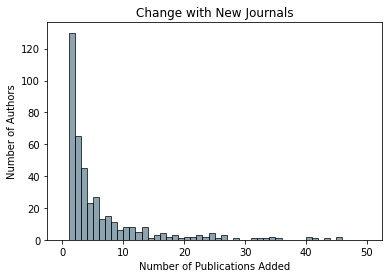

<Figure size 432x288 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dif, bins=50, range=(0,50), edgecolor='black', alpha=0.7, color='#607c8e')

# Add title and labels
plt.title('Change with New Journals')
plt.xlabel('Number of Publications Added')
plt.ylabel('Number of Authors')

# Show the plot
plt.show()
plt.savefig('change_in_results.png')
